In [1]:
# Load libraries
import math
import sys
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import signal
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential,  Model
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from keras.layers import MaxPooling2D, Conv2D, MaxPooling1D, Conv1D, Dense, Flatten, AveragePooling1D, LSTM, Dropout, Input, Concatenate, LeakyReLU, BatchNormalization, Activation
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from google.colab import files
from numpy import savetxt
from keras.layers import Layer
np.random.seed(5080)
tf.random.set_seed(5080)

In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load raw ultrasonic data
data1 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean1.npz')
data2 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean2.npz')
data3 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean3.npz')
data4 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean4.npz')
data5 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean5.npz')

In [4]:
# Get training time
def truncate(n,i):
  return math.floor(n*10**i)/10**i

train_time = np.concatenate((data1['Time'], data2['Time'], data3['Time'], data4['Time'], data5['Time']), axis=None)
ttime = [truncate(i,2) for i in train_time]
print(np.shape(ttime))
ttime = np.reshape(ttime, (np.shape(ttime)[0], 1))
print(ttime)
print(np.shape(ttime))

del train_time

(1324032,)
[[2102.67]
 [2102.67]
 [2102.67]
 ...
 [3426.96]
 [3426.96]
 [3426.96]]
(1324032, 1)


In [5]:
# Collect raw ultrasonic data
train_data = np.concatenate((data1['AcData'], data2['AcData'], data3['AcData'], data4['AcData'], data5['AcData']), axis=0)
print(train_data)
print(np.shape(train_data))

[[ 21   9  26 ... -31 -33 -45]
 [ 17  20  28 ... -25 -30 -41]
 [  8  10  17 ... -17 -20 -38]
 ...
 [ 21  30  29 ... 232 242 238]
 [ 27  10  20 ... 248 239 228]
 [ 58  93 111 ... 249 224 216]]
(1324032, 1568)


In [6]:
# Delete raw ultrasonic data
del data1, data2, data3, data4, data5

In [7]:
# Combine ultrasound data & time
ttime = pd.DataFrame(ttime).rename(columns={0:'Time'})
full_df = ttime.join(pd.DataFrame(train_data))
print(full_df)
del train_data, ttime

            Time   0   1    2    3    4   5   6   7   8  ...  1558  1559  \
0        2102.67  21   9   26   20   31  43  25  20  31  ...     4    -6   
1        2102.67  17  20   28   24   29  40  40  35  44  ...    -6   -10   
2        2102.67   8  10   17   13   32  45  29  25  22  ...     2    -9   
3        2102.67   2   5   14    8   17  21  11  15  19  ...     3     2   
4        2102.67  15  15   10   22   29  34  19  19  27  ...    -1     3   
...          ...  ..  ..  ...  ...  ...  ..  ..  ..  ..  ...   ...   ...   
1324027  3426.96  24  22   18   36   36  26  24  19  21  ...   248   260   
1324028  3426.96  24  16   21   32   31  27  22  15  34  ...   258   261   
1324029  3426.96  21  30   29   30   25  35  34  30  36  ...   268   275   
1324030  3426.96  27  10   20   29   28  29  38  21  25  ...   265   258   
1324031  3426.96  58  93  111  124  115  89  44  35  19  ...   256   269   

         1560  1561  1562  1563  1564  1565  1566  1567  
0           1    -2   -11   -

In [8]:
# Drop duplicate time data
full_df = full_df.drop_duplicates(subset=['Time'], keep='last').reset_index(drop=True)
full_df = full_df.set_index('Time')
print(full_df)

         0     1     2     3     4     5     6     7     8     9     ...  \
Time                                                                 ...   
2102.67    20    17    14    13    35    49    37    37    23    19  ...   
2102.68    10    16    20    13    34    34    33    37    24    16  ...   
2102.69    18    14    18    28    23    31    26    22    20     4  ...   
2102.70    26    13    22    26    25    35    25    25    40    14  ...   
2102.71    14    11     9    20    31    34    29     2     5    13  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
3426.92     9    18    19    16    41    23    12    29    18     3  ...   
3426.93    17    24    16    23    19    17    20    21    28    12  ...   
3426.94    10    12    25    13    27    50    25    27    19     2  ...   
3426.95     3    15    21    23    39    38    21    23    22    15  ...   
3426.96    58    93   111   124   115    89    44    35    19   -14  ...   

         15

In [9]:
# Load shear stress data
data = loadmat('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
m_t = m_t[:][175604:175604+132400].reset_index(drop=True)
print(m_t)

           Time        SS
0       2102.91  5.657157
1       2102.92  5.658317
2       2102.93  5.659499
3       2102.94  5.660404
4       2102.95  5.661648
...         ...       ...
132395  3426.86  5.474545
132396  3426.87  5.478286
132397  3426.88  5.481751
132398  3426.89  5.484813
132399  3426.90  5.487332

[132400 rows x 2 columns]


In [10]:
# Merge raw ultrasonic data & shear stress based on time
# Prepare input data (xdf): raw ultrasonic signal
# Prepare output data (ydf): shear stress
df = full_df.reset_index().merge(m_t, on='Time').reset_index(drop=True)
xdf = df.drop(['Time', 'SS'], axis=1)
ydf = df[['SS']]
print(xdf)
print(ydf)

        0     1     2     3     4     5     6     7     8     9     ...  1558  \
0         16    23    16    31    33    27    24    26    32    17  ...     0   
1         15    19    32    30    31    40    34    28    37    17  ...    -5   
2          9    16    20    27    36    44    21    10    26    12  ...    28   
3         26    24    21    22    27    36    28    24    17     7  ...    -5   
4         10    14    24    28    35    36    26    25    17    20  ...    -4   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
132371    25    37    15    19    39    30    35    30    21    28  ...   253   
132372    20    14     7    10    27    18    21    21    32    21  ...   254   
132373    22     9    17    27    33    29    15    14     5    17  ...   260   
132374    24    17     8    18    31    46    36    19    34    24  ...   266   
132375    17    20    33    33    38    39    27    17    19    25  ...   257   

        1559  1560  1561  1

In [11]:
# Split data in train-val-test (72-8-20)
x_train, x_test1, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train1, X_val1, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.125, shuffle=False)

del x_train, y_train

In [12]:
# Reshape data & scaling
X_train = np.reshape(X_train1.values, (-1,1))
X_val = np.reshape(X_val1.values, (-1,1))
x_test = np.reshape(x_test1.values, (-1,1))

del X_train1, X_val1, x_test1

sc = MinMaxScaler(feature_range=(-1,1))
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
x_test = sc.transform(x_test)

X_train = np.reshape(X_train, (-1,1568))
X_val = np.reshape(X_val, (-1,1568))
x_test = np.reshape(x_test, (-1,1568))

print(X_train.shape, X_val.shape, x_test.shape)
print(Y_train.shape, Y_val.shape,y_test.shape)

(92662, 1568) (13238, 1568) (26476, 1568)
(92662, 1) (13238, 1) (26476, 1)


In [13]:
# Reshape in the tensor form
X_train = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(np.array(X_val), (X_val.shape[0], X_val.shape[1], 1))
x_test = np.reshape(np.array(x_test), (x_test.shape[0], x_test.shape[1], 1))
print(X_train.shape, X_val.shape, x_test.shape)

(92662, 1568, 1) (13238, 1568, 1) (26476, 1568, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inp (InputLayer)                │ (None, 1568, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1469, 32)       │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1469, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1469, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 145, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 16)         │        25,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 96, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 18, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 18, 5)          │            85 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 5)          │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 18, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Features (Flatten)              │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,151 (113.87 KB)

 Trainable params: 29,045 (113.46 KB)

 Non-trainable params: 106 (424.00 B)

None
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['inp']
Received: inputs=Tensor(shape=(None, 1568, 1))
  warnings.warn(msg)


2896/2896 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2716

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['inp']
Received: inputs=Tensor(shape=(None, 1568, 1))
  warnings.warn(msg)



Epoch 1: val_loss improved from inf to 0.23907, saving model to /content/drive/My Drive/Colab Notebooks/p5270/XAI/Attention_Layer/Check1.keras
2896/2896 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.2715 - val_loss: 0.2391
Epoch 2/10
2886/2896 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092
Epoch 2: val_loss did not improve from 0.23907
2896/2896 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0093 - val_loss: 0.2706
Epoch 3/10
2894/2896 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087
Epoch 3: val_loss did not improve from 0.23907
2896/2896 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0087 - val_loss: 0.4496
Epoch 4/10
2884/2896 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 4: val_loss improved from 0.23907 to 0.03664, saving model to /content/drive/My Drive/Colab Notebooks/p5270/XAI/Attention_Layer/Check1.keras
2896/2896 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0089 - val_loss: 0.0366
Epoch 5/10
2890/2896 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077
Epoch 5: val_loss improved 

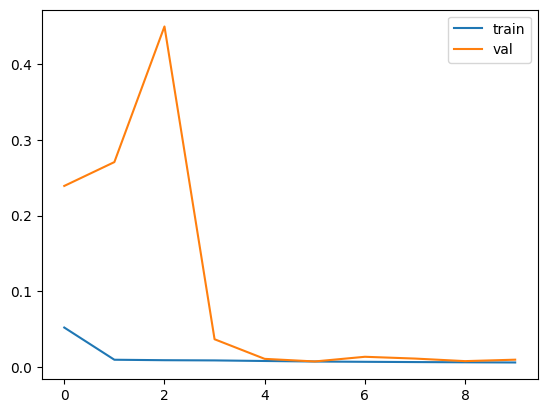

In [14]:
# Define model

# Input Signal
inp = Input(shape=(X_train.shape[1:]), name='inp')

# CNN 1
conv1 = Conv1D(32,100)(inp)
bn = BatchNormalization()(conv1)
act = Activation(LeakyReLU())(bn)
pool1 = MaxPooling1D(pool_size=20, strides=10)(act)

# CNN 2
conv2 = Conv1D(16,50)(pool1)
bn = BatchNormalization()(conv2)
act = Activation(LeakyReLU())(bn)
pool2 = MaxPooling1D(pool_size=10, strides=5)(act)

# CNN 3
conv3 = Conv1D(5,1)(pool2)
bn = BatchNormalization()(conv3)
act = Activation(LeakyReLU())(bn)
pool3 = MaxPooling1D(pool_size=2, strides=20)(act)

# Extract Features
f2 = Flatten(name='Features')(pool3)

# Regression
op = Dense(1,activation='linear')(f2)

model = Model(inputs=[inp], outputs=[op])

# Model: compile, summary & fit
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='auto')  #Stops when accuracy is no longer changing
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/p5270/XAI/Attention_Layer/Check1.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  #Saves best model so far, add .keras extension to the file name
callbacks_list = [earlystop, checkpoint]
print(model.summary())

history = model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1, callbacks=callbacks_list, validation_data=(X_val, Y_val))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [15]:
# Extracted features (training set)
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Features').output)
intermediate_output_train = intermediate_layer_model.predict(X_train)
print(intermediate_output_train.shape)
# for i in range(0,intermediate_output_train.shape[1], 2):
#   fig = plt.figure(i, figsize=(20,4))
#   mc = pd.DataFrame(intermediate_output_train[:,i])
#   plt.plot(mc)
#   plt.ylabel('Feature')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['inp']
Received: inputs=Tensor(shape=(32, 1568, 1))
  warnings.warn(msg)


2896/2896 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
(92662, 5)


In [16]:
# Extracted features (validation set)
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Features').output)
intermediate_output_val = intermediate_layer_model.predict(X_val)
print(intermediate_output_val.shape)
# for i in range(0,intermediate_output_val.shape[1], 2):
#   fig = plt.figure(i, figsize=(20,4))
#   mc = pd.DataFrame(intermediate_output_val[:,i])
#   plt.plot(mc)
#   plt.ylabel('Feature')

414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(13238, 5)


In [17]:
# Extracted features (test set)
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Features').output)
intermediate_output_test = intermediate_layer_model.predict(x_test)
print(intermediate_output_test.shape)
# for i in range(0,intermediate_output_test.shape[1], 2):
#   fig = plt.figure(i, figsize=(20,4))
#   mc = pd.DataFrame(intermediate_output_test[:,i])
#   plt.plot(mc)
#   plt.ylabel('Feature')

828/828 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
(26476, 5)


In [18]:
# Extract Data
savetxt('intermediate_output_train.csv', intermediate_output_train, delimiter=',')
savetxt('intermediate_output_val.csv', intermediate_output_val, delimiter=',')
savetxt('intermediate_output_test.csv', intermediate_output_test, delimiter=',')

In [19]:
# Download
files.download('intermediate_output_train.csv')
files.download('intermediate_output_val.csv')
files.download('intermediate_output_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>